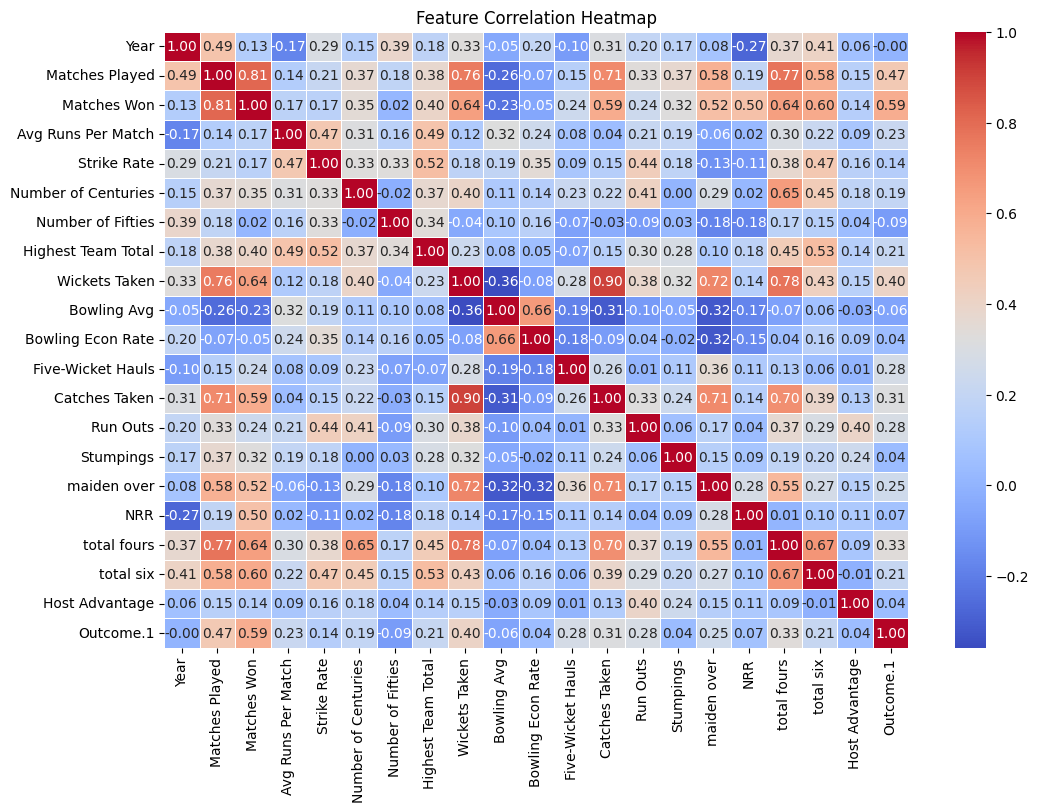

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "Cleaned_Train_Data.csv"
df = pd.read_csv(file_path)

# Select only numerical features for correlation
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix using only numerical features
correlation_matrix = numerical_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize correlations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Set title
plt.title("Feature Correlation Heatmap")

# Show plot
plt.show()

Features with High VIF (>10) to be removed: ['Year', 'Matches Played', 'Matches Won', 'Avg Runs Per Match', 'Strike Rate', 'Highest Team Total', 'Wickets Taken', 'Bowling Econ Rate', 'Catches Taken', 'maiden over', 'NRR', 'total fours']


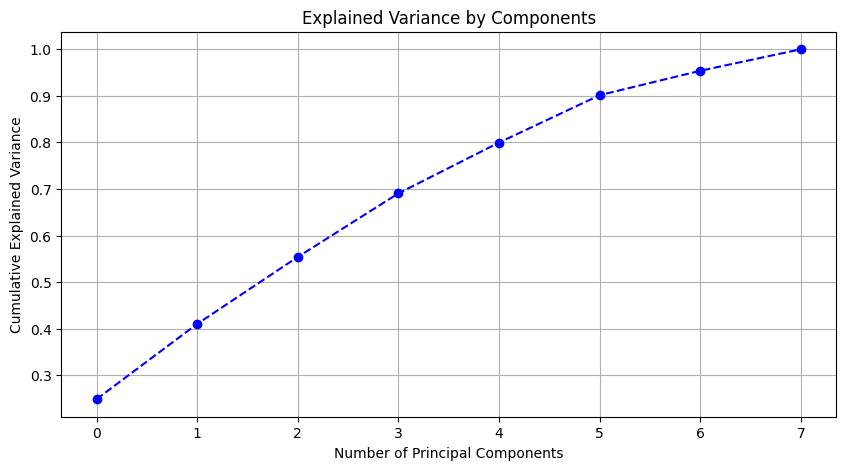

Number of Components to retain 95% variance: 7
Transformed dataset after PCA:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7
0  0.552554 -1.804440 -2.046454 -0.174967 -0.782584  0.570791  0.287632
1 -0.251967  0.278823 -0.571089 -0.706838  0.318345 -0.167873 -0.555391
2  0.260980  0.954655  0.065356  0.076747 -0.163386 -0.054658  0.021838
3 -1.351153  1.269418  0.455455 -0.786286 -2.615608  0.722015  0.775910
4  0.220621 -0.324838  2.859542  0.049866 -0.503732  1.423226 -0.448478


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "/content/Cleaned_Train_Data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Drop non-numeric columns (if any)
df_numeric = df.select_dtypes(include=[np.number])

# Drop target variable if present
target_column = 'Outcome.1'  # Change if your target variable has a different name
if target_column in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=[target_column])

# --------------------- 1️⃣ Calculate VIF ---------------------
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_df = calculate_vif(df_numeric)

# Filter out high VIF features (VIF > 10)
high_vif_features = vif_df[vif_df["VIF"] > 10]["Feature"].tolist()
print("Features with High VIF (>10) to be removed:", high_vif_features)

df_vif_filtered = df_numeric.drop(columns=high_vif_features)

# --------------------- 2️⃣ Apply PCA ---------------------
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_vif_filtered)

# Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Components")
plt.grid(True)
plt.show()

# Select number of components (retain 95% variance)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of Components to retain 95% variance: {n_components}")

# Transform data using selected components
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

# Convert PCA output back to DataFrame
pca_columns = [f"PC{i+1}" for i in range(n_components)]
df_pca = pd.DataFrame(df_pca, columns=pca_columns)

print("Transformed dataset after PCA:\n", df_pca.head())



In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Load the dataset
file_path = "Cleaned_Train_Data.csv"
df = pd.read_csv(file_path)

# Separate features and target variable
target_column = 'Outcome.1'
X = df.drop(columns=[target_column])
y = df[target_column]

# Define categorical and numerical features
categorical_features = ['Team', 'Group']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features) # One-hot encode categorical features
    ])

# Combine preprocessing and PCA in a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=7))
])

# Apply the pipeline to your data
X_pca = pipeline.fit_transform(X)

# Create a DataFrame with PCA-transformed features
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

# Add the target variable back
df_pca[target_column] = y

# Save the transformed dataset
output_filename = "PCA_Transformed_Data.csv"
df_pca.to_csv(output_filename, index=False)

print(f"PCA Transformed dataset saved successfully at: {os.path.abspath(output_filename)}")
print(df_pca.head())

PCA Transformed dataset saved successfully at: /content/PCA_Transformed_Data.csv
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.878324 -0.785835 -2.548681 -0.786240 -0.241594 -1.523728  0.910894   
1 -0.209236  0.480531 -1.405230 -0.436072 -0.668515 -0.679625 -0.819002   
2 -1.392873  2.174824 -1.609378  0.492060 -0.367021 -0.477533 -0.118803   
3 -3.910840  2.846477 -2.156175 -0.347605 -0.333717  1.124423  1.251184   
4 -2.243031  0.592228 -1.379492  1.687329  1.698051  1.093412  0.792442   

   Outcome.1  
0          1  
1          0  
2          0  
3          0  
4          0  


In [ ]:
import pandas as pd

# Load the PCA transformed dataset
pca_file_path = "/content/PCA_Transformed_Data.csv"  # Update path if needed
df_pca = pd.read_csv(pca_file_path)

# Load the original dataset (update path if required)
original_file_path = "/content/Cleaned_Train_Data.csv"  # Update the actual file path
df_original = pd.read_csv(original_file_path)

# 1️⃣ Check unique values in Outcome column
print("Unique values in Outcome column:", df_pca['Outcome.1'].unique())

# 2️⃣ Check for missing values
missing_values = df_pca['Outcome.1'].isnull().sum()
print(f"Missing values in Outcome column: {missing_values}")

# 3️⃣ Compare with the original dataset
print("\nOriginal dataset Outcome column (first 5 rows):")
print(df_original[['Outcome.1']].head())

print("\nPCA Transformed dataset Outcome column (first 5 rows):")
print(df_pca[['Outcome.1']].head())

# 4️⃣ Verify the column data type
print("\nData type of Outcome column:", df_pca['Outcome.1'].dtype)

# 5️⃣ Fix the Outcome column if it's incorrectly formatted
if df_pca['Outcome.1'].dtype == 'object':  # If stored as string
    df_pca['Outcome.1'] = df_pca['Outcome.1'].astype(int)  # Convert to integer
    print("\nOutcome column data type fixed.")

# Save the corrected dataset (if any fixes were made)
df_pca.to_csv("/content/PCA_Transformed_Data_Corrected.csv", index=False)
print("\nCorrected dataset saved successfully!")



Unique values in Outcome column: [1 0]
Missing values in Outcome column: 0

Original dataset Outcome column (first 5 rows):
   Outcome.1
0          1
1          0
2          0
3          0
4          0

PCA Transformed dataset Outcome column (first 5 rows):
   Outcome.1
0          1
1          0
2          0
3          0
4          0

Data type of Outcome column: int64

Corrected dataset saved successfully!


In [ ]:
import numpy as np

# Check class distribution
class_counts = np.bincount(df_pca["Outcome.1"])
print(f"Class distribution: {dict(enumerate(class_counts))}")


Class distribution: {0: 49, 1: 7}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:26:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[9 2]
 [0 1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.33      1.00      0.50         1

    accuracy                           0.83        12
   macro avg       0.67      0.91      0.70        12
weighted avg       0.94      0.83      0.87        12



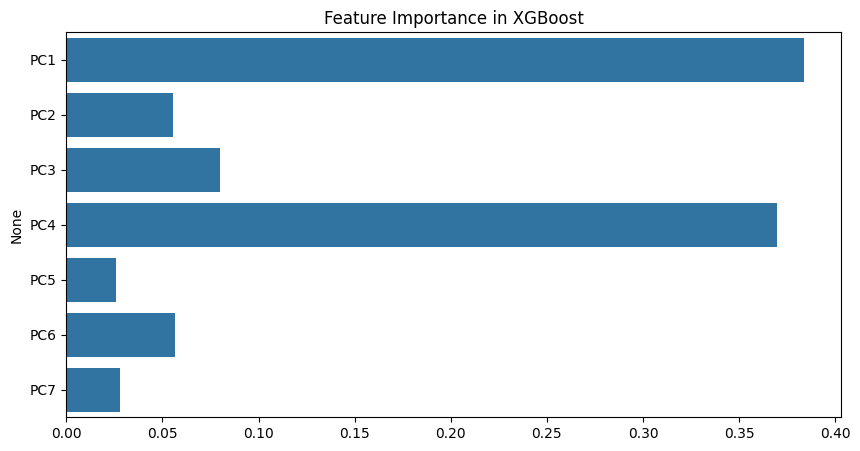

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load PCA-transformed dataset
pca_file_path = "/content/PCA_Transformed_Data.csv"  # Change path if needed
df_pca = pd.read_csv(pca_file_path)

# Separate features (X) and target (y)
X = df_pca.drop(columns=['Outcome.1'])  # Features
y = df_pca['Outcome.1']  # Target variable (Winner:1, Non-Winner:0)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Class distribution (for imbalance handling)
class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]  # Adjusted for imbalance

# Initialize and train XGBoost classifier
xgb_model = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,  # Handling imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,  # Can be tuned
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance (optional)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.title("Feature Importance in XGBoost")
plt.show()


Original Class Distribution: {0: 49, 1: 7}
Balanced Class Distribution: {1: 49, 0: 49}

Confusion Matrix:
 [[10  0]
 [ 2  8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:26:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


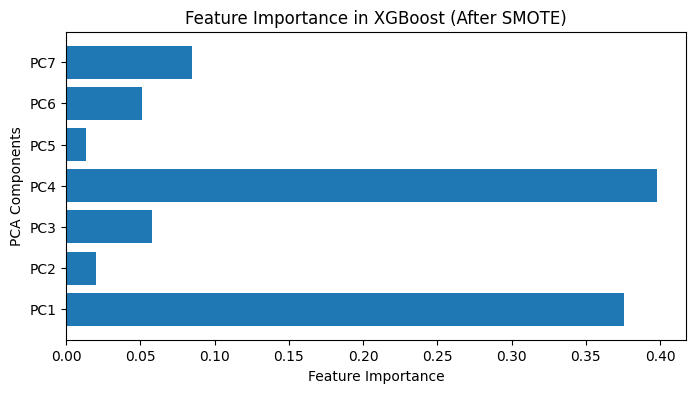

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the PCA transformed dataset
df = pd.read_csv("PCA_Transformed_Data.csv")

# Separate features and target
X = df.drop(columns=['Outcome.1'])  # Features
y = df['Outcome.1']  # Target variable

# Check initial class distribution
print("Original Class Distribution:", y.value_counts().to_dict())

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("Balanced Class Distribution:", y_resampled.value_counts().to_dict())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train XGBoost on balanced data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)  # No need to adjust weight now
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(8, 4))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("PCA Components")
plt.title("Feature Importance in XGBoost (After SMOTE)")
plt.show()


In [ ]:
import pandas as pd

# Save the balanced dataset
balanced_dataset = pd.concat([X_resampled, y_resampled], axis=1)
balanced_dataset.to_csv("balanced_dataset.csv", index=False)

print("Balanced dataset saved successfully!")


Balanced dataset saved successfully!


Accuracy: 0.90
Confusion Matrix:
 [[ 8  2]
 [ 0 10]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



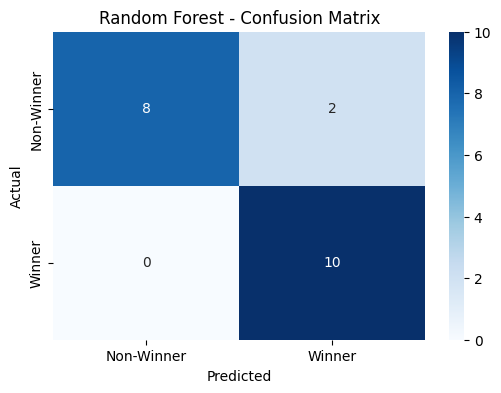

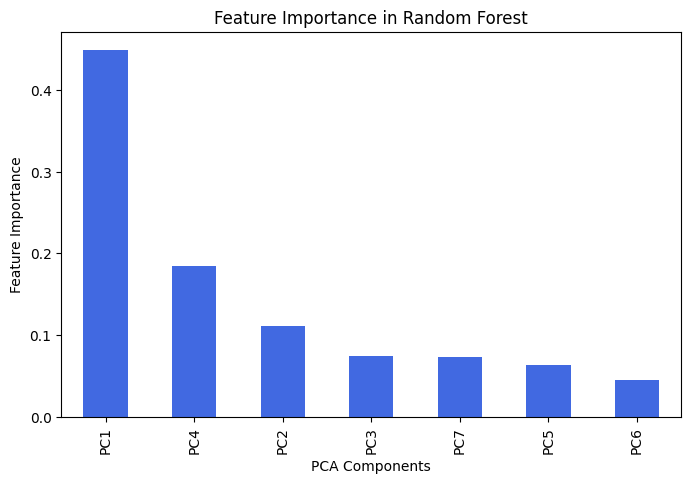

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the balanced dataset
df = pd.read_csv('/content/balanced_dataset.csv')  # Update filename if needed

# Separate features and target
X = df.drop(columns=['Outcome.1'])  # Features
y = df['Outcome.1']  # Target

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Winner', 'Winner'], yticklabels=['Non-Winner', 'Winner'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
feature_importances.plot(kind='bar', color='royalblue')
plt.title('Feature Importance in Random Forest')
plt.xlabel('PCA Components')
plt.ylabel('Feature Importance')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Define and train the Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")


Random Forest Model Trained Successfully!


In [ ]:
# Get predictions for training data
y_train_preds = model_rf.predict(X_train)

# Convert predictions into a DataFrame for better visualization
train_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_preds})

# Count how many times each team is predicted as a winner
predicted_winner_counts = train_results[train_results['Predicted'] == 1].value_counts()

# Display the most frequent predicted winners
print("Predicted Winners in Training Data (Frequency Count):")
print(predicted_winner_counts)


Predicted Winners in Training Data (Frequency Count):
Actual  Predicted
1       1            39
Name: count, dtype: int64


In [ ]:
# Add team names to the predictions DataFrame
train_results['Team'] = X_train.index  # Assuming team names are stored in the index

# Filter only predicted winners
winning_teams = train_results[train_results['Predicted'] == 1]['Team']

# Count occurrences of each team being predicted as a winner
team_winner_counts = winning_teams.value_counts()

# Display the most frequently predicted winning team
print("Most Predicted Winning Team(s):")
print(team_winner_counts)



Most Predicted Winning Team(s):
Team
77    1
81    1
94    1
61    1
97    1
86    1
73    1
92    1
91    1
64    1
71    1
78    1
93    1
95    1
75    1
59    1
40    1
87    1
90    1
89    1
82    1
72    1
84    1
0     1
58    1
79    1
63    1
85    1
66    1
67    1
16    1
32    1
60    1
80    1
88    1
96    1
69    1
70    1
24    1
Name: count, dtype: int64


In [ ]:
# Assuming 'Team' column was in your original dataset (df)

# Load the original dataset
original_df = pd.read_csv("Cleaned_Train_Data.csv")  # Or the path where your original data is saved

# ----> Create a dictionary mapping index to team name <----
team_mapping = dict(zip(original_df.index, original_df['Team']))

# ----> Use map to get team names from winning_teams indices <----
winning_teams = train_results[train_results['Predicted'] == 1].index
predicted_team_names = winning_teams.map(team_mapping)

team_winner_counts = predicted_team_names.value_counts()

print("Most Likely Winning Team(s):")
print(team_winner_counts)

Most Likely Winning Team(s):
Australia       2
South Africa    1
West Indies     1
India           1
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd

# Initialize Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on balanced dataset
logreg.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = logreg.predict(X_train)

# Model evaluation
accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred)
class_report = classification_report(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print(f"F1 Score: {f1:.2f}")

# Predicting winners in the training set
train_predictions_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
winning_teams = train_predictions_df[train_predictions_df['Predicted'] == 1]

# Mapping team indices to actual country names (assuming you have a dictionary 'team_mapping')
winning_team_counts = winning_teams['Actual'].map(team_mapping).value_counts()

# Display most likely winning team(s)
print("Most Likely Winning Team(s):\n", winning_team_counts)


Accuracy: 0.94
Confusion Matrix:
 [[34  5]
 [ 0 39]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        39
           1       0.89      1.00      0.94        39

    accuracy                           0.94        78
   macro avg       0.94      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78

F1 Score: 0.94
Most Likely Winning Team(s):
 Actual
West Indies     39
South Africa     5
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd

# Initialize and train the Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# Make predictions
y_pred = gb.predict(X_train)

# Evaluate model performance
accuracy = accuracy_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)
report = classification_report(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

# Convert predicted winners to team names
predicted_winners = X_train[y_pred == 1]  # Select only the predicted winners
# ----> Use map to substitute index values with corresponding team names from the 'team_mapping' dictionary. <----
predicted_winners['Team'] = predicted_winners.index.map(team_mapping)
winner_counts = predicted_winners['Team'].value_counts()  # Count occurrences

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print(f"F1 Score: {f1:.2f}")
print("\nMost Likely Winning Team(s):")
print(winner_counts)

Accuracy: 1.00
Confusion Matrix:
 [[39  0]
 [ 0 39]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

F1 Score: 1.00

Most Likely Winning Team(s):
Team
Australia       2
South Africa    1
West Indies     1
India           1
Name: count, dtype: int64


<ipython-input-17-6a47ad48ad12>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_winners['Team'] = predicted_winners.index.map(team_mapping)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_train)

# Accuracy and classification report
accuracy_dt = accuracy_score(y_train, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_train, y_pred_dt)
class_report_dt = classification_report(y_train, y_pred_dt)

# Display results
print(f"Accuracy: {accuracy_dt:.2f}")
print("Confusion Matrix:\n", conf_matrix_dt)
print("Classification Report:\n", class_report_dt)

# Find the most predicted winning team
predicted_winners_dt = pd.DataFrame(y_pred_dt, columns=['Predicted'])
predicted_winners_dt = predicted_winners_dt.value_counts().reset_index(name='count')

# Map the predicted team numbers to actual team names
predicted_winners_dt['Team'] = predicted_winners_dt['Predicted'].map(team_mapping)

# Display most likely winning team(s)
print("Most Likely Winning Team(s):")
print(predicted_winners_dt[['Team', 'count']])


Accuracy: 1.00
Confusion Matrix:
 [[39  0]
 [ 0 39]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

Most Likely Winning Team(s):
           Team  count
0  South Africa     39
1   West Indies     39


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pandas as pd

# Initialize MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Predictions on the training data
y_pred_train = mlp.predict(X_train)

# Model Evaluation
accuracy = accuracy_score(y_train, y_pred_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
class_report = classification_report(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)

# Print Model Performance
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print(f"F1 Score: {f1:.2f}")

# Extracting the predicted winners
predicted_winners = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train})
predicted_winners = predicted_winners[predicted_winners['Predicted'] == 1]  # Only winners

# Count the most frequently predicted winning teams
predicted_winners_count = predicted_winners['Actual'].value_counts()

# Mapping team IDs to country names
team_mapping = {
    0: 'India', 1: 'Australia', 2: 'England', 3: 'South Africa', 4: 'New Zealand',
    5: 'Pakistan', 6: 'Sri Lanka', 7: 'West Indies', 8: 'Bangladesh', 9: 'Afghanistan'
}

# Convert team IDs to actual country names
predicted_winners_count.index = predicted_winners_count.index.map(team_mapping)

# Print the most likely winning teams
print("\nMost Likely Winning Team(s):")
print(predicted_winners_count)


Accuracy: 1.00
Confusion Matrix:
 [[39  0]
 [ 0 39]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        39

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

F1 Score: 1.00

Most Likely Winning Team(s):
Actual
Australia    39
Name: count, dtype: int64


Random Forest Model Performance:
Accuracy: 0.95
F1 Score: 0.949874686716792
Confusion Matrix:
 [[10  0]
 [ 1  9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

--------------------------------------------------
Gradient Boosting Model Performance:
Accuracy: 0.9
F1 Score: 0.898989898989899
Confusion Matrix:
 [[10  0]
 [ 2  8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

----------------

<Figure size 1000x500 with 0 Axes>

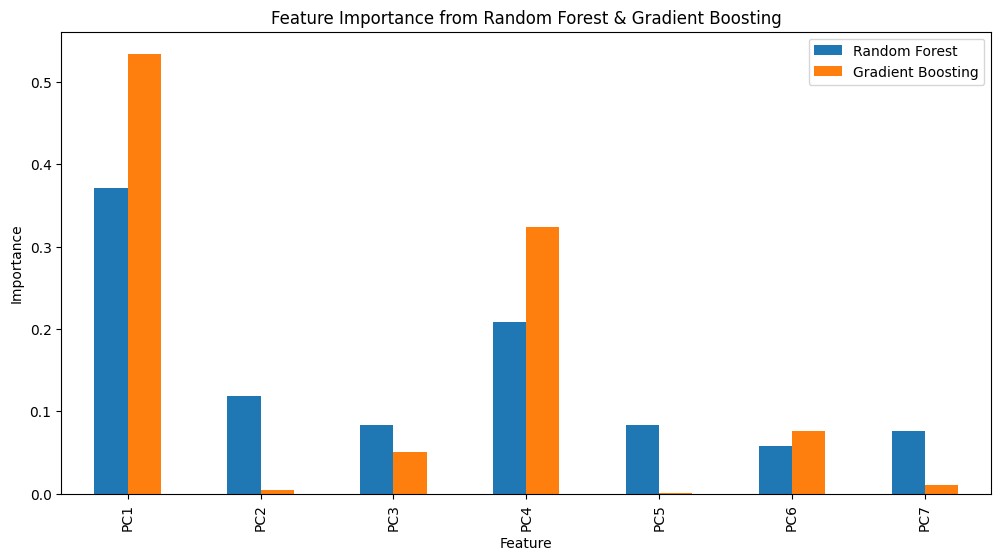

Ensemble Learning Performance:
Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[10  0]
 [ 0 10]]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset (replace with actual dataset path)
# df = pd.read_csv('your_dataset.csv')
X = df.drop(columns=['Outcome.1'])  # Features
y = df['Outcome.1']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize for models like MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    if name == "MLP Classifier":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {"Accuracy": acc, "F1 Score": f1, "Confusion Matrix": conf_matrix}
    predictions[name] = y_pred

    print(f"{name} Model Performance:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

# Visualize feature importance for tree-based models
plt.figure(figsize=(10,5))
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': models["Random Forest"].feature_importances_,
    'Gradient Boosting': models["Gradient Boosting"].feature_importances_
})
feature_importance_df.set_index('Feature').plot(kind='bar', figsize=(12,6))
plt.title("Feature Importance from Random Forest & Gradient Boosting")
plt.ylabel("Importance")
plt.show()

# Ensemble Learning (Majority Voting)
ensemble_preds = pd.DataFrame(predictions).mode(axis=1)[0]
ensemble_acc = accuracy_score(y_test, ensemble_preds)
ensemble_f1 = f1_score(y_test, ensemble_preds, average='weighted')
print("Ensemble Learning Performance:")
print("Accuracy:", ensemble_acc)
print("F1 Score:", ensemble_f1)
print("Confusion Matrix:\n", confusion_matrix(y_test, ensemble_preds))


Random Forest Accuracy: 0.95
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Confusion Matrix:
[[10  0]
 [ 1  9]]
Gradient Boosting Accuracy: 0.90
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Confusion Matrix:
[[10  0]
 [ 2  8]]
Logistic Regression Accuracy: 0.90
Logistic Regression Classification Report:
              precision    recall  f1-score   support


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Classifier Accuracy: 1.00
MLP Classifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Confusion Matrix:
[[10  0]
 [ 0 10]]

Comparison of Model Predictions:
                    Predicted Winner
Random Forest              Australia
Gradient Boosting          Australia
Logistic Regression     South Africa
Decision Tree              Australia
MLP Classifier          South Africa


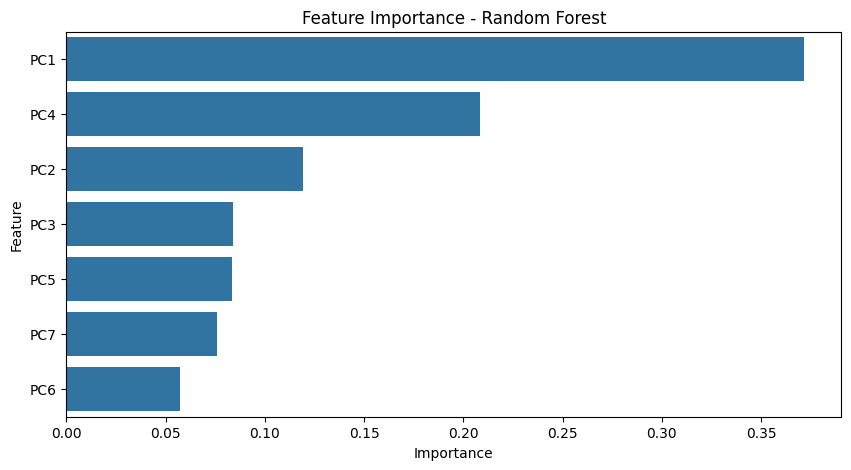

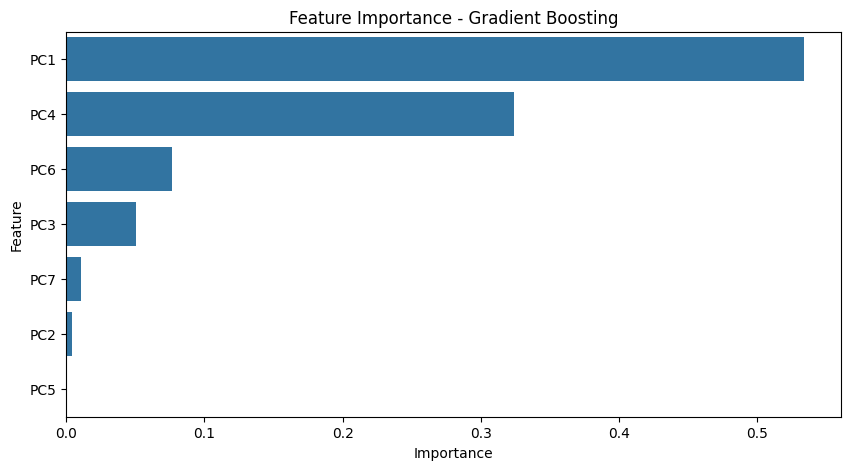

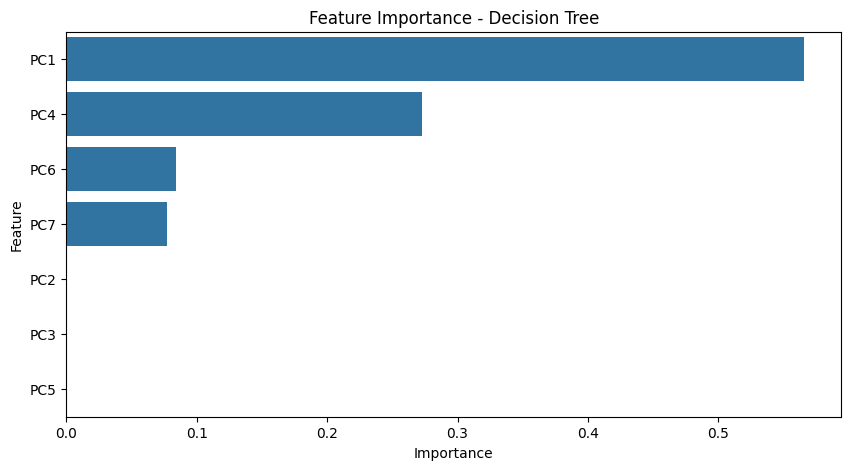


Final Predicted Winner by Majority Voting: Australia


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset (Replace with actual dataset)
df = pd.read_csv("/content/balanced_dataset.csv")

# Feature selection and preprocessing (Modify as per dataset)
X = df.drop(columns=['Outcome.1'])  # Features
y = df['Outcome.1']  # Target variable (Encoded as team indexes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store model predictions
model_predictions = {}

# Dictionary to map team index to team name (Modify as per dataset)
team_mapping = {0: 'Australia', 1: 'South Africa', 2: 'West Indies', 3: 'India'}

def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Classification Report:\n{f1}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Convert numerical predictions to country names
    predicted_winner = pd.Series(y_pred).map(team_mapping).value_counts()
    model_predictions[model_name] = predicted_winner.idxmax()

    return model, predicted_winner

# Train models and get predictions
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

for model_name, model in models.items():
    train_and_evaluate(model, model_name)

# Display comparison of predictions
comparison_df = pd.DataFrame.from_dict(model_predictions, orient='index', columns=['Predicted Winner'])
print("\nComparison of Model Predictions:")
print(comparison_df)

# Feature Importance Visualization (for tree-based models)
def plot_feature_importance(model, model_name):
    feature_importance = model.feature_importances_
    feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    feature_df = feature_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feature_df)
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

# Plot feature importance for Random Forest and Gradient Boosting
for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, model_name)

# Majority Voting to find the most predicted winner
final_winner = comparison_df['Predicted Winner'].mode()[0]
print(f"\nFinal Predicted Winner by Majority Voting: {final_winner}")

Random Forest Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Gradient Boosting Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Decision Tree Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.70      0.82        10

    accuracy                           0.85        20
   macro avg       0.88      0.85    

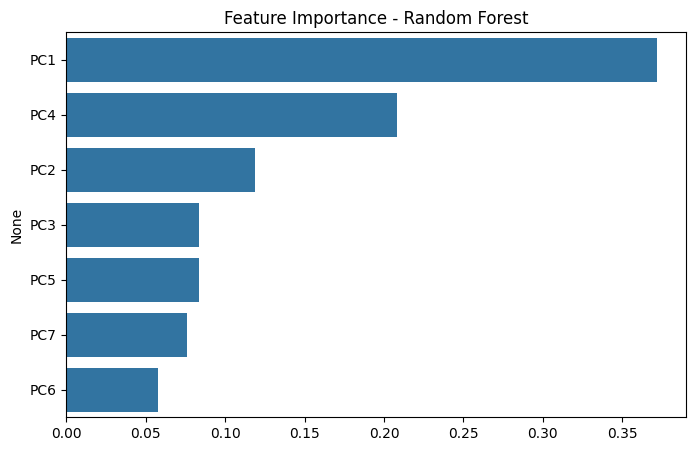

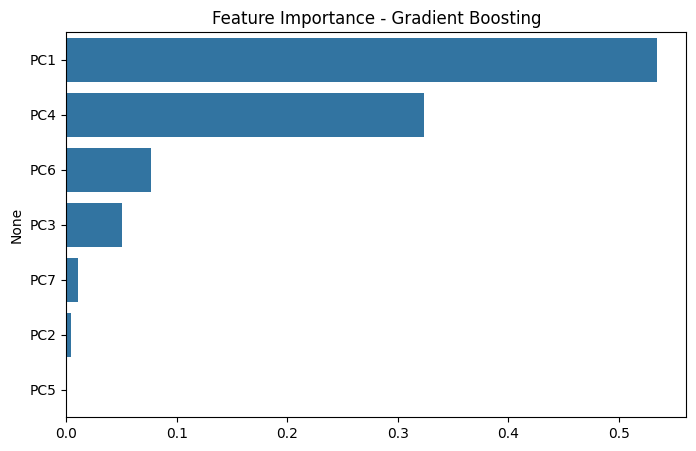

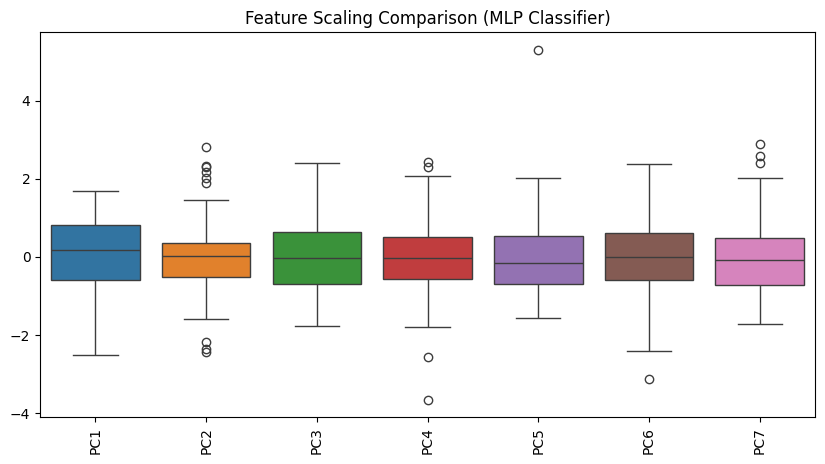

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset (Assuming df is already preprocessed)
X = df.drop(columns=['Outcome.1'])  # Features
y = df['Outcome.1']  # Target

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling for MLP Classifier
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Initialization
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Dictionary to store results
results = {}
predictions = {}

# Train & Evaluate Models
for name, model in models.items():
    if name == 'MLP Classifier':  # MLP requires scaled features
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    predictions[name] = y_pred
    print(f"{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))

# Mapping numeric predictions to country names
team_mapping = {0: 'Australia', 1: 'South Africa', 2: 'West Indies', 3: 'India'}  # Example mapping
predicted_winners = {name: pd.Series(pred).map(team_mapping).mode()[0] for name, pred in predictions.items()}

# Display predicted winners
print("\nPredicted Winners:")
for model, winner in predicted_winners.items():
    print(f"{model}: {winner}")

# Majority Voting
final_winner = pd.Series(predicted_winners).mode()[0]
print(f"\nFinal Predicted Winner (Majority Voting): {final_winner}")

# Feature Importance Visualization (Only for tree-based models)
def plot_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importance[sorted_idx], y=X.columns[sorted_idx])
        plt.title(f'Feature Importance - {model_name}')
        plt.show()

plot_feature_importance(models['Random Forest'], 'Random Forest')
plot_feature_importance(models['Gradient Boosting'], 'Gradient Boosting')

# Feature Scaling Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(X_train_scaled, columns=X.columns))
plt.title("Feature Scaling Comparison (MLP Classifier)")
plt.xticks(rotation=90)
plt.show()

Dataset Head:
   Year          Team Group  Matches Played  Matches Won  Avg Runs Per Match  \
0   0.0  South Africa     A            0.50         0.75            0.917373   
1   0.0   West Indies     A            0.50         0.50            0.853814   
2   0.0         India     A            0.25         0.25            0.900424   
3   0.0     Australia     A            0.00         0.00            0.887712   
4   0.0   New Zealand     A            0.25         0.25            0.713983   

   Strike Rate  Number of Centuries  Number of Fifties  Highest Team Total  \
0     0.567689             0.333333                0.0            0.757576   
1     0.525383             0.333333                0.4            0.780303   
2     0.550238             0.333333                0.6            0.848485   
3     0.586727             0.000000                0.2            0.681818   
4     0.367002             0.000000                0.6            0.670455   

   ...  Five-Wicket Hauls  Catches T

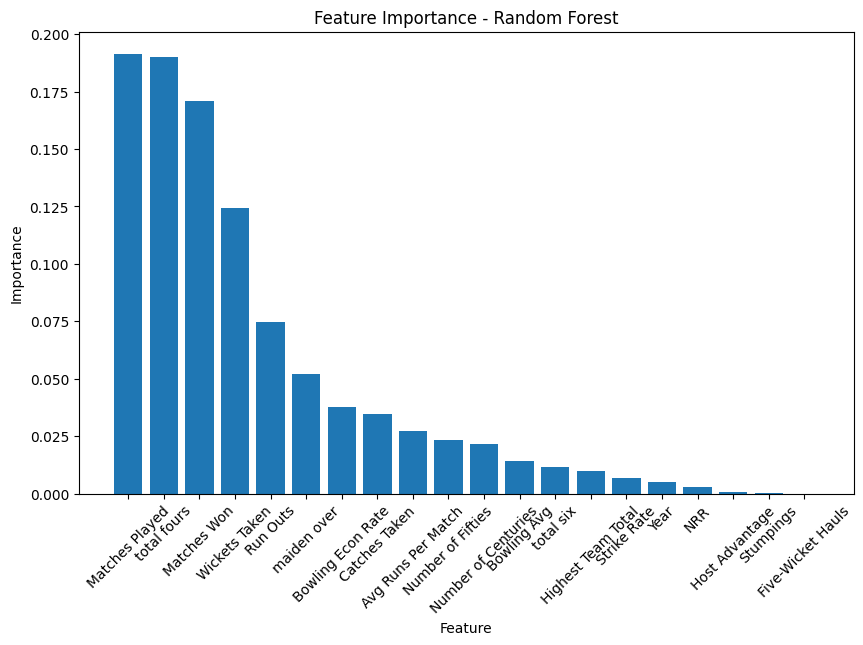

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Step 1: Load and Perform EDA
def load_and_explore_data(filepath):
    df = pd.read_csv('/content/Cleaned_Train_Data.csv')
    print("Dataset Head:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nClass Distribution:")
    print(df['Outcome.1'].value_counts())
    return df

# Step 2: Feature Scaling
# Step 2: Feature Scaling
def scale_features(X_train, X_test):
    # Select only numerical features for scaling
    numerical_features = X_train.select_dtypes(include=np.number).columns

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[numerical_features])
    X_test_scaled = scaler.transform(X_test[numerical_features])
    return X_train_scaled, X_test_scaled

# Step 3: Data Balancing using SMOTE
def balance_data(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', k_neighbors=min(3, y_train.value_counts().min()-1))
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    return X_train_bal, y_train_bal

# Step 4: Train Models
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced'),
        'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
    }

    results, predictions = {}, {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        results[name] = {
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'conf_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }
        print(f"\n{name} Model:\n")
        print(classification_report(y_test, y_pred))

    return results, predictions

# Step 5: Determine Final Winner
def determine_winner(predictions, team_mapping):
    pred_df = pd.DataFrame(predictions)
    pred_winner_counts = pred_df.mode().T[0].map(team_mapping).value_counts()
    print("\nMost Likely Winning Team(s):")
    print(pred_winner_counts)
    final_winner = pred_winner_counts.idxmax()
    print(f"Final Predicted Winner: {final_winner}")
    return final_winner

# Step 6: Visualize Feature Importance
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    # ----> Use only numerical_features that were used for training <----
    plt.bar(range(len(numerical_features)), importances[indices[:len(numerical_features)]], align='center')
    plt.xticks(range(len(numerical_features)), np.array(numerical_features)[indices[:len(numerical_features)]], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

# Load dataset
filepath = 'dataset.csv'  # Change to actual dataset path
df = load_and_explore_data(filepath)

# Prepare dataset
X = df.drop(columns=['Outcome.1'])
y = df['Outcome.1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
X_train_bal, y_train_bal = balance_data(X_train_scaled, y_train)

# Train models
results, predictions = train_models(X_train_bal, X_test_scaled, y_train_bal, y_test)

# Team Mapping (Update as per dataset)
team_mapping = {0: 'Australia', 1: 'India', 2: 'South Africa', 3: 'West Indies'}
final_winner = determine_winner(predictions, team_mapping)

# Feature Importance Plot
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
plot_feature_importance(rf_model, X.columns, "Feature Importance - Random Forest")
